# ***Importing Packages and Dataset***

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import time
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import NearMiss
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
df = pd.read_csv("heart.csv")

In [5]:
df.head()
#df.shape
# df.describe()
# df.info()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


# ***Numerical and Categorical Features***

In [4]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # Catgeorical Variable Selection
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]
    num_but_cat = [col for col in dataframe.columns if
                   dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ["uint8", "int64", "float64"]]
    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].nunique() > car_th and str(dataframe[col].dtypes) in ["category", "object"]]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # Numerical Variable Selection
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8", "int64", "float64"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [5]:
# Print Categorical and Numerical Variables
print(f"Observations: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")
print(f"Cat_cols: {len(cat_cols)}")
print(f"Num_cols: {len(num_cols)}")
print(f"Cat_but_car: {len(cat_but_car)}")


Observations: 4238
Variables: 16
Cat_cols: 8
Num_cols: 8
Cat_but_car: 0


   male     Ration
0  2419  57.078811
1  1819  42.921189
##########################################


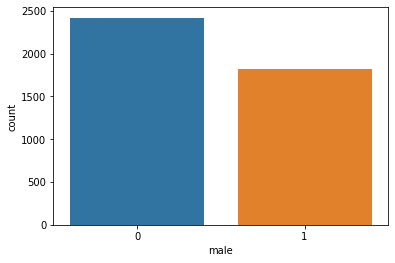

     education     Ration
1.0       1720  40.585182
2.0       1253  29.565833
3.0        687  16.210477
4.0        473  11.160925
##########################################


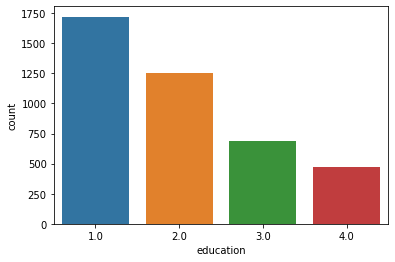

   currentSmoker     Ration
0           2144  50.589901
1           2094  49.410099
##########################################


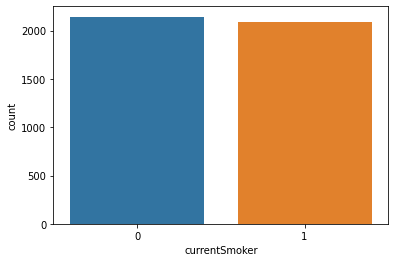

     BPMeds     Ration
0.0    4061  95.823502
1.0     124   2.925908
##########################################


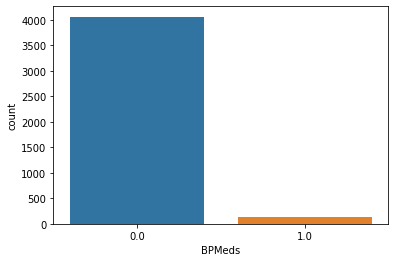

   prevalentStroke     Ration
0             4213  99.410099
1               25   0.589901
##########################################


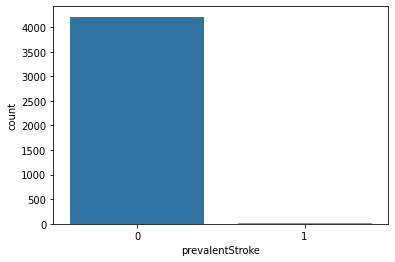

   prevalentHyp     Ration
0          2922  68.947617
1          1316  31.052383
##########################################


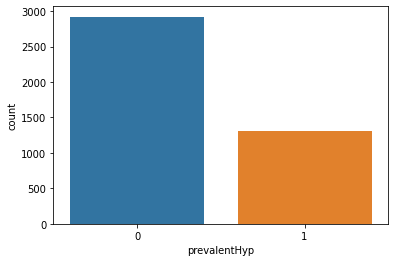

   diabetes     Ration
0      4129  97.428032
1       109   2.571968
##########################################


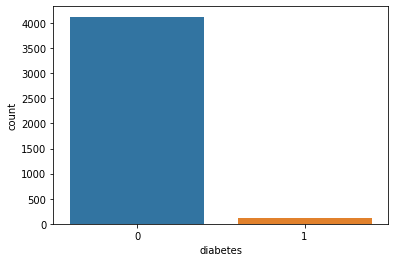

   TenYearCHD     Ration
0        3594  84.804153
1         644  15.195847
##########################################


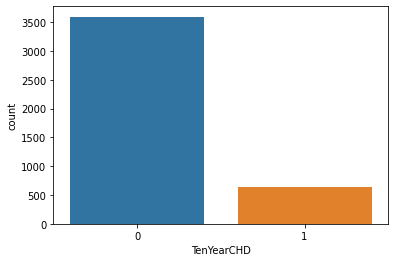

None


In [6]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        'Ration': 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)


def cat_summary_df(dataframe):
    cat_cols, num_cols, cat_but_car = grab_col_names(df)
    for col in cat_cols:
        cat_summary(dataframe, col, plot=True)

print(cat_summary_df(df))

count    4238.000000
mean       49.584946
std         8.572160
min        32.000000
1%         35.000000
5%         37.000000
10%        39.000000
20%        41.000000
30%        44.000000
40%        46.000000
50%        49.000000
60%        52.000000
70%        55.000000
80%        58.000000
90%        62.000000
95%        64.000000
99%        67.000000
max        70.000000
Name: age, dtype: float64


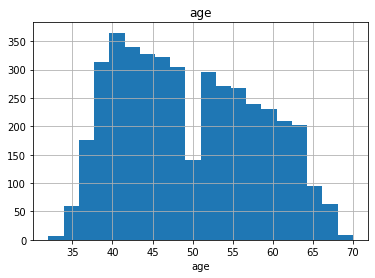

count    4209.000000
mean        9.003089
std        11.920094
min         0.000000
1%          0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         9.000000
70%        15.000000
80%        20.000000
90%        25.000000
95%        30.000000
99%        43.000000
max        70.000000
Name: cigsPerDay, dtype: float64


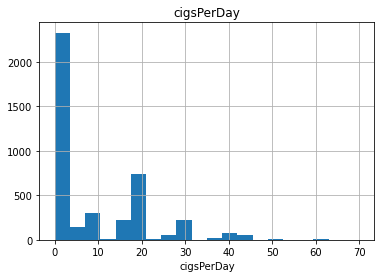

count    4188.000000
mean      236.721585
std        44.590334
min       107.000000
1%        153.000000
5%        170.000000
10%       183.000000
20%       200.000000
30%       212.000000
40%       223.000000
50%       234.000000
60%       244.000000
70%       257.000000
80%       271.000000
90%       292.000000
95%       312.000000
99%       354.130000
max       696.000000
Name: totChol, dtype: float64


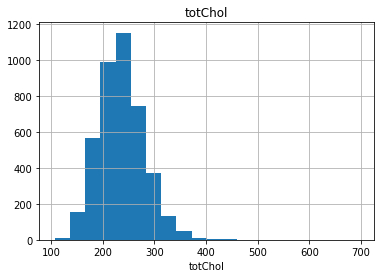

count    4238.000000
mean      132.352407
std        22.038097
min        83.500000
1%         97.000000
5%        104.000000
10%       108.850000
20%       114.000000
30%       119.500000
40%       124.000000
50%       128.000000
60%       133.000000
70%       140.000000
80%       148.000000
90%       162.000000
95%       175.000000
99%       200.000000
max       295.000000
Name: sysBP, dtype: float64


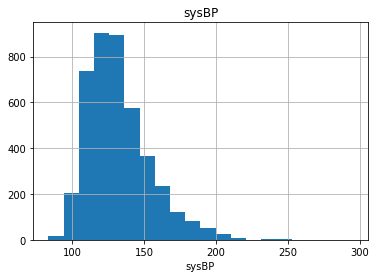

count    4238.000000
mean       82.893464
std        11.910850
min        48.000000
1%         60.000000
5%         66.000000
10%        69.000000
20%        73.000000
30%        76.000000
40%        80.000000
50%        82.000000
60%        85.000000
70%        87.500000
80%        92.000000
90%        98.000000
95%       104.575000
99%       118.000000
max       142.500000
Name: diaBP, dtype: float64


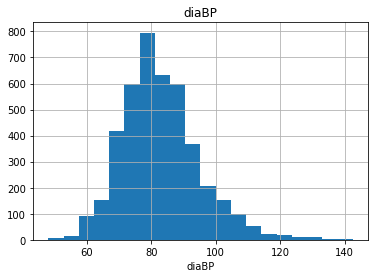

count    4219.000000
mean       25.802008
std         4.080111
min        15.540000
1%         18.163600
5%         20.060000
10%        21.088000
20%        22.530000
30%        23.564000
40%        24.470000
50%        25.400000
60%        26.350000
70%        27.420000
80%        28.690000
90%        30.770000
95%        32.782000
99%        38.956400
max        56.800000
Name: BMI, dtype: float64


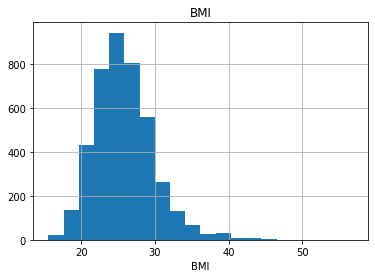

count    4237.000000
mean       75.878924
std        12.026596
min        44.000000
1%         52.000000
5%         60.000000
10%        60.000000
20%        65.000000
30%        70.000000
40%        72.000000
50%        75.000000
60%        77.000000
70%        80.000000
80%        85.000000
90%        92.000000
95%        98.000000
99%       110.000000
max       143.000000
Name: heartRate, dtype: float64


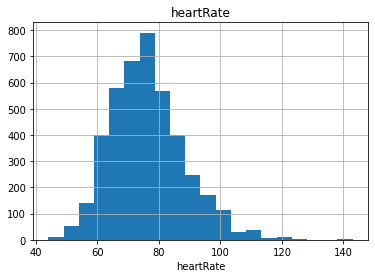

count    3850.000000
mean       81.966753
std        23.959998
min        40.000000
1%         55.000000
5%         62.000000
10%        65.000000
20%        70.000000
30%        73.000000
40%        75.000000
50%        78.000000
60%        81.000000
70%        85.000000
80%        89.000000
90%        98.000000
95%       108.550000
99%       175.040000
max       394.000000
Name: glucose, dtype: float64


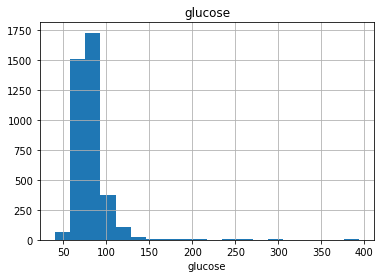

None


In [7]:
def num_summary(dataframe, num_col, plot=False):
  quantiles = [0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(dataframe[num_col].describe(quantiles).T)

  if plot:
    dataframe[num_col].hist(bins=20)
    plt.xlabel(num_col)
    plt.title(num_col)
    plt.show(block=True)

def num_summary_df(dataframe):
  cat_cols, num_cols, cat_but_car = grab_col_names(df)
  for col in num_cols:
    num_summary(dataframe, col, plot=True)

print(num_summary_df(df))

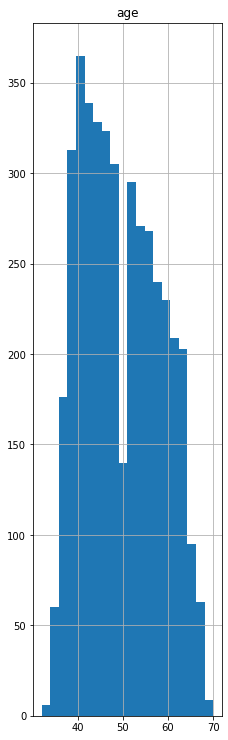

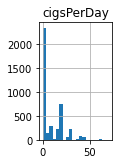

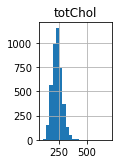

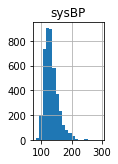

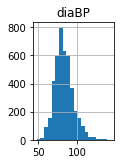

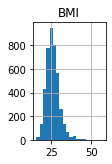

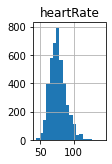

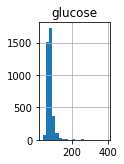

None


In [8]:
def plot_num_summary(dataframe):
  cat_cols, num_cols, cat_but_car = grab_col_names(dataframe)
  plt.figure(figsize=(12, 20))
  for index, col in enumerate(num_cols):
    plt.subplot(2, 4, index+1)
    plt.tight_layout()
    dataframe[col].hist(bins=20)
    plt.title(col)
    plt.show()

print(plot_num_summary(df))

In [9]:
# def target_summary_with_num(dataframe, target, numerical_col):
#   print(dataframe.groupby(target).agg({numerical_col: "mean"}))
#   print("#############################################")

# def target_summary_with_num_df(dataframe, target):
#   cat_cols, num_cols, cat_but_car = grab_col_names(df)
#   for col in num_cols:
#     target_summary_with_num(dataframe, target, col)

# print(target_summary_with_num_df(df,'Outcome'))


# ***EDA- Histplot and Boxplot***

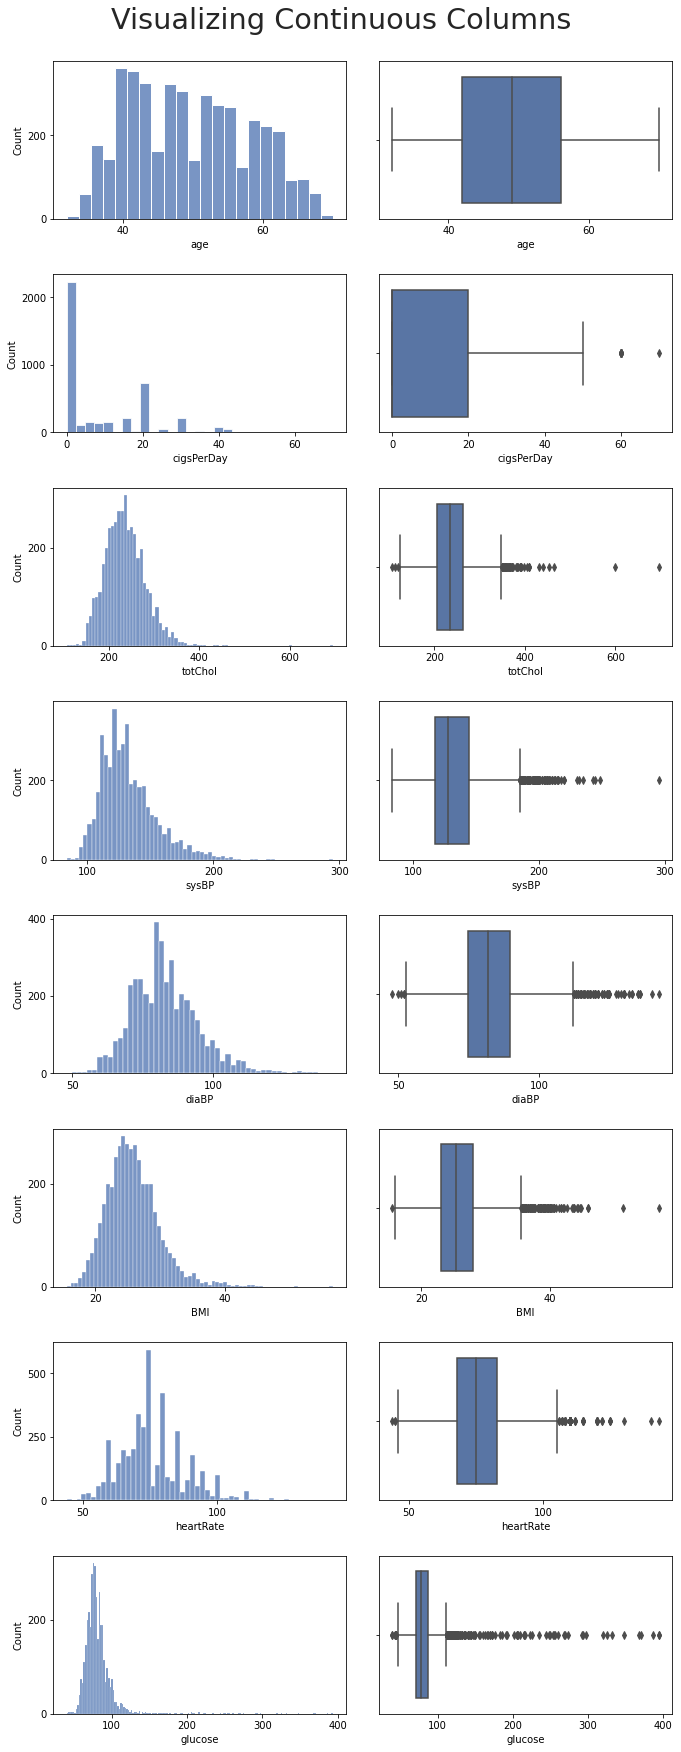

None


In [10]:
import scipy.stats as stats
def exploratory_data(dataframe):
    import warnings
    warnings.filterwarnings('ignore')
    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe)
    fig, ax = plt.subplots(8, 2, figsize=(10, 25))
    sns.set(font_scale=2)
    for index, col in enumerate(num_cols):
        sns.histplot(dataframe[col], ax=ax[index, 0])
        sns.boxplot(dataframe[col], ax=ax[index, 1])
        # stats.probplot(dataframe[col], plot=ax[index, 2])
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.suptitle("Visualizing Continuous Columns")
    plt.show()

print(exploratory_data(df))

# ***Visualizing Missing Data***
We can use seaborn to create a simple heatmap to see where we are missing data!

In [11]:
df.isnull()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4234,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4235,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
4236,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


<AxesSubplot:>

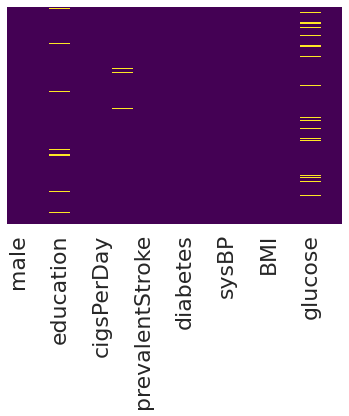

In [12]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# ***Cleaning***

In [13]:
df.corr()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
male,1.000000,-0.028979,0.017352,0.197596,0.317930,-0.052506,-0.004546,0.005313,0.015708,-0.070322,-0.035989,0.057933,0.081672,-0.116620,0.006083,0.088428
age,-0.028979,1.000000,-0.165883,-0.213748,-0.192791,0.122995,0.057655,0.307194,0.101258,0.262131,0.394302,0.206104,0.135800,-0.012823,0.122256,0.225256
education,0.017352,-0.165883,1.000000,0.018532,0.008085,-0.010815,-0.035112,-0.081970,-0.038680,-0.023115,-0.129631,-0.062316,-0.137504,-0.054206,-0.035721,-0.054059
currentSmoker,0.197596,-0.213748,0.018532,1.000000,0.769690,-0.048938,-0.032988,-0.103260,-0.044295,-0.046562,-0.130230,-0.107746,-0.167650,0.062356,-0.056826,0.019456
cigsPerDay,0.317930,-0.192791,0.008085,0.769690,1.000000,-0.046134,-0.032707,-0.066146,-0.037067,-0.026320,-0.088780,-0.056632,-0.092856,0.075157,-0.058960,0.057884
BPMeds,-0.052506,0.122995,-0.010815,-0.048938,-0.046134,1.000000,0.117365,0.261187,0.052047,0.080558,0.254219,0.194227,0.100668,0.015233,0.051176,0.087489
prevalentStroke,-0.004546,0.057655,-0.035112,-0.032988,-0.032707,0.117365,1.000000,0.074830,0.006949,0.000067,0.057009,0.045190,0.025891,-0.017676,0.018431,0.061810
prevalentHyp,0.005313,0.307194,-0.081970,-0.103260,-0.066146,0.261187,0.074830,1.000000,0.077808,0.163993,0.696755,0.615751,0.301318,0.147261,0.086834,0.177603
diabetes,0.015708,0.101258,-0.038680,-0.044295,-0.037067,0.052047,0.006949,0.077808,1.000000,0.040278,0.111283,0.050329,0.087036,0.048994,0.617627,0.097317
totChol,-0.070322,0.262131,-0.023115,-0.046562,-0.026320,0.080558,0.000067,0.163993,0.040278,1.000000,0.208908,0.165182,0.115767,0.091125,0.046408,0.082184


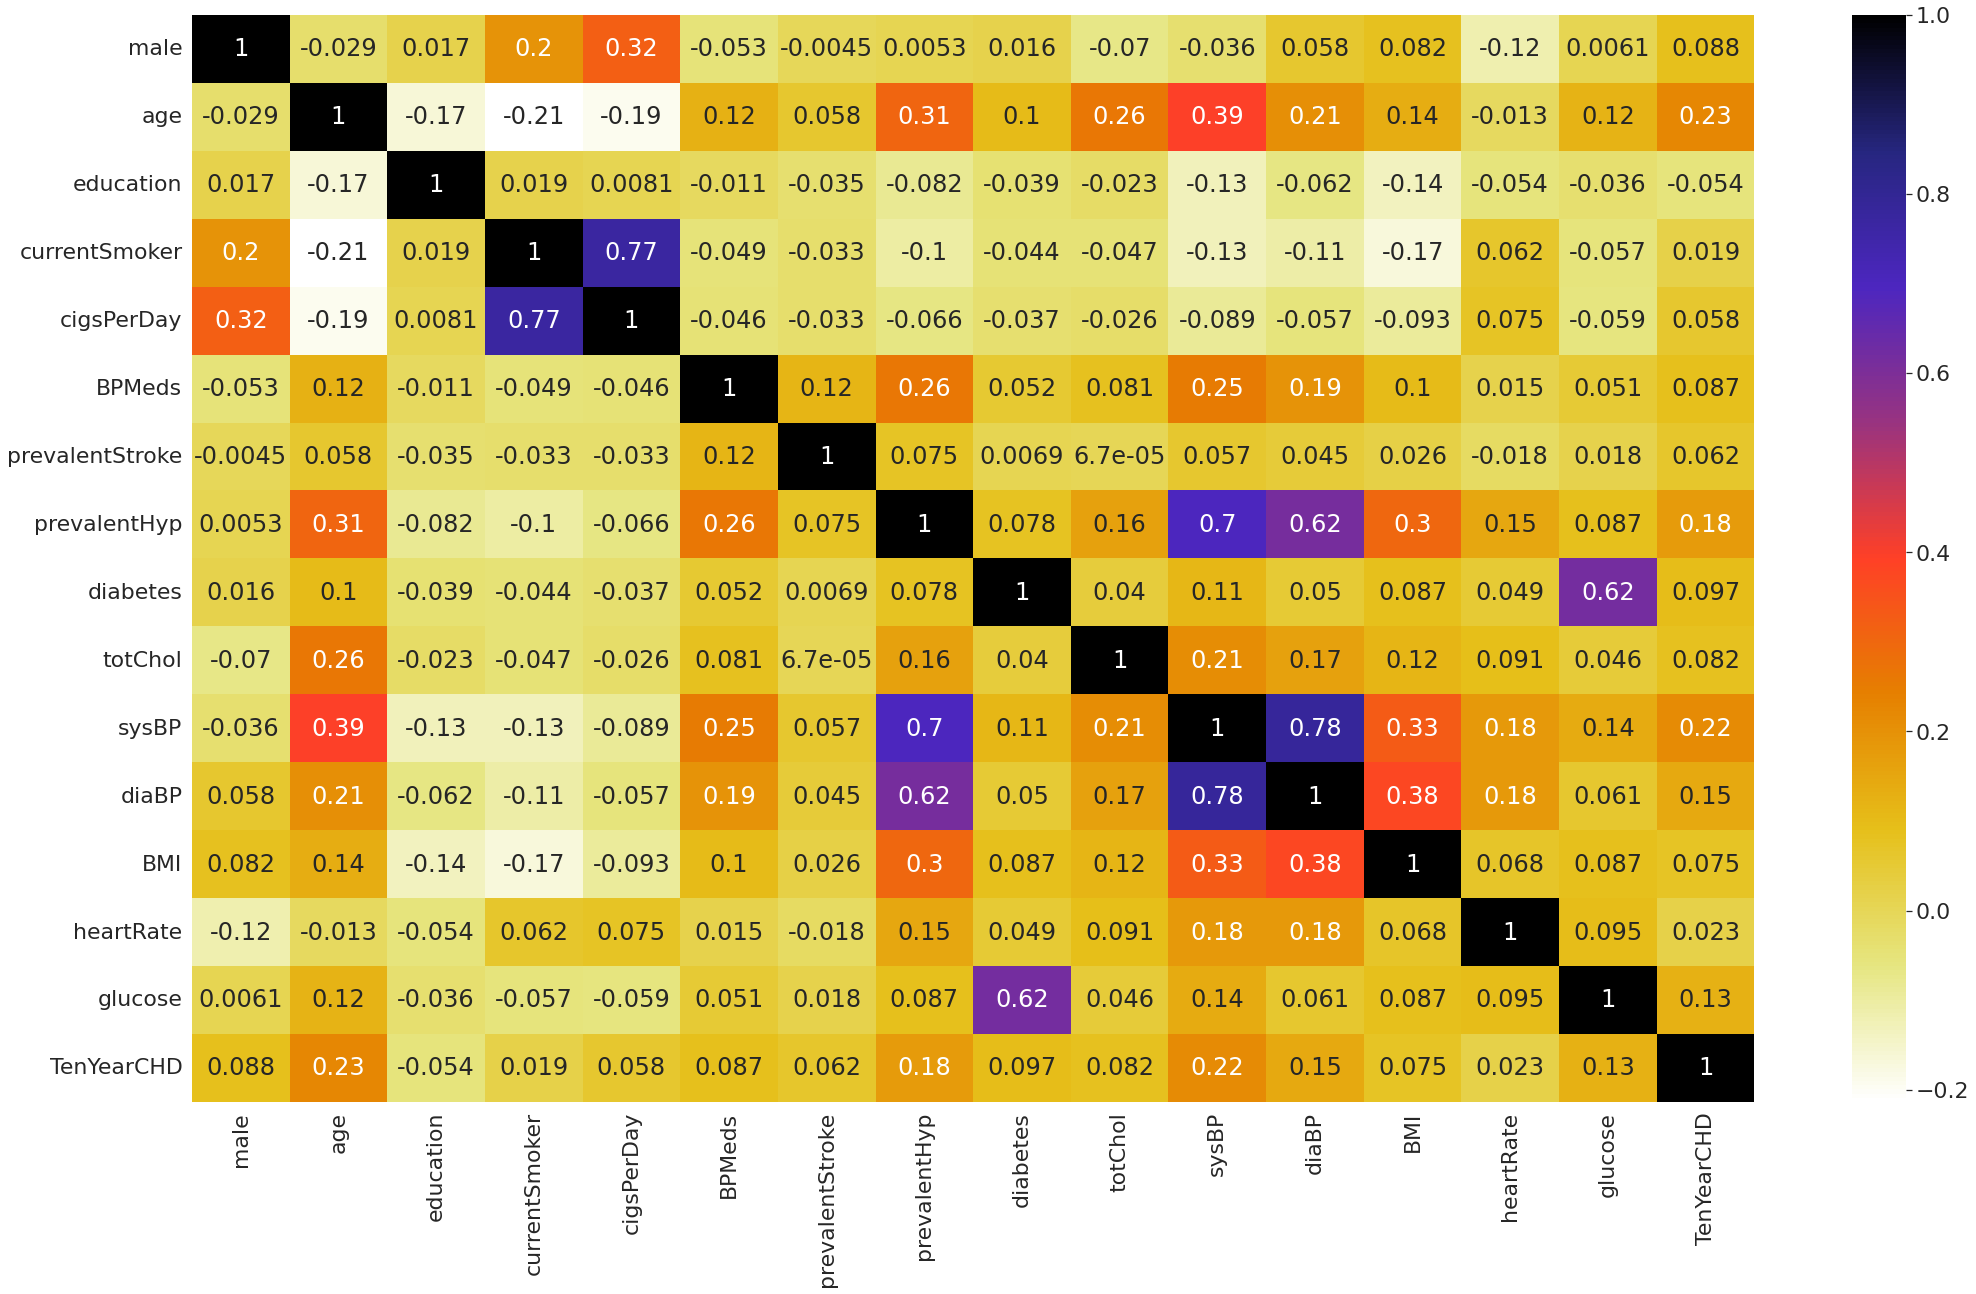

In [14]:
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(35,20))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

# ***Handling Missing Values***

In [15]:
df['cigsPerDay'] = df['cigsPerDay'].fillna(df['cigsPerDay'].mode()[0])
df['education'] = df['education'].fillna(df['education'].median())
df['BPMeds'] = df['BPMeds'].fillna(df['BPMeds'].mode()[0])
df['totChol'] = df['totChol'].fillna(df['totChol'].median())
df['BMI'] = df['BMI'].fillna(df['BMI'].median())
df['heartRate'] = df['heartRate'].fillna(df['heartRate'].median())
df['glucose'] = df['glucose'].fillna(df['glucose'].median())

In [16]:
df.isnull().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

# ***Handling Imbalanced Data***

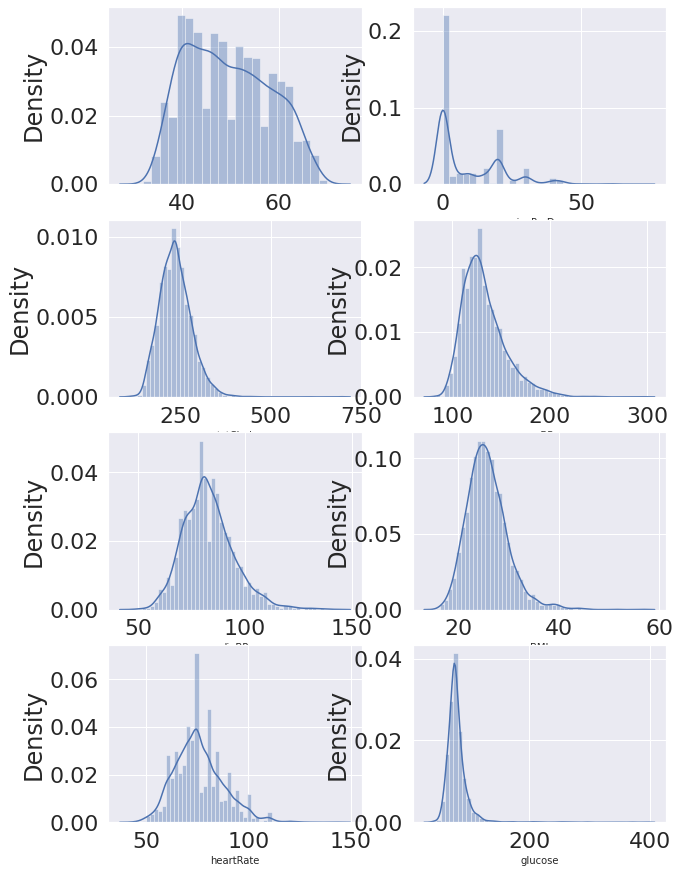

In [17]:
columns = ['age','cigsPerDay','totChol','sysBP','diaBP','BMI','heartRate','glucose']

plt.figure(figsize=(10,15),facecolor='white')
plotnumber = 1

for column in columns:
    ax = plt.subplot(4,2,plotnumber)
    sns.distplot(df[column])
    plt.xlabel(column,fontsize=10)
    plotnumber+=1
plt.show()

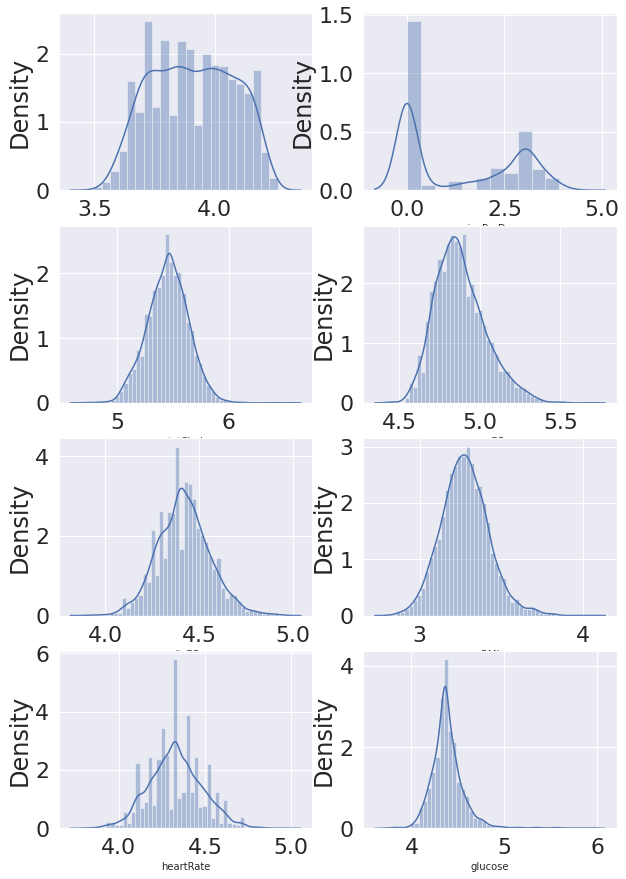

In [18]:
columns = ['age','cigsPerDay','totChol','sysBP','diaBP','BMI','heartRate','glucose']

plt.figure(figsize=(10,15),facecolor='white')
plotnumber = 1

for column in columns:
    df[column]+=1
    ax = plt.subplot(4,2,plotnumber)
    sns.distplot(np.log(df[column]))
    plt.xlabel(column,fontsize=10)
    plotnumber+=1
plt.show()

<AxesSubplot:xlabel='TenYearCHD', ylabel='count'>

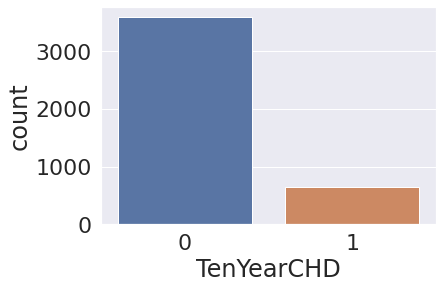

In [19]:
sns.countplot(df['TenYearCHD'])

In [20]:
X = df.drop(['TenYearCHD'],axis=1)
y = df['TenYearCHD']
rdsmple = RandomOverSampler()
x_sampled,y_sampled  = rdsmple.fit_resample(X,y)

In [21]:
x_sampled.shape

(7188, 15)

In [22]:
x_sampled = pd.DataFrame(data = x_sampled, columns = X.columns)

<AxesSubplot:xlabel='TenYearCHD', ylabel='count'>

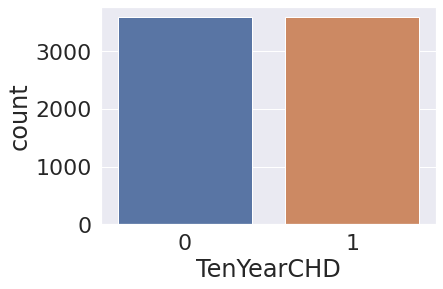

In [23]:
sns.countplot(y_sampled)

In [24]:
x_sampled.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
count,7188.000000,7188.000000,7188.000000,7188.000000,7188.000000,7188.000000,7188.000000,7188.000000,7188.000000,7188.000000,7188.000000,7188.000000,7188.000000,7188.000000,7188.000000
mean,0.468141,52.473706,1.925431,0.499026,10.614775,0.044101,0.009878,0.393294,0.039789,241.090568,138.061839,85.557526,27.164996,77.214663,85.102115
std,0.499019,8.657016,1.018408,0.500034,12.467184,0.205334,0.098901,0.488515,0.195476,45.621149,24.595234,12.938316,4.311167,12.138353,30.019453
min,0.000000,33.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,108.000000,84.500000,49.000000,16.540000,45.000000,41.000000
25%,0.000000,45.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,211.000000,121.000000,77.000000,24.270000,69.000000,74.000000
50%,0.000000,52.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,237.000000,133.000000,84.000000,26.740000,76.000000,79.000000
75%,1.000000,60.000000,3.000000,1.000000,21.000000,0.000000,0.000000,1.000000,0.000000,267.000000,151.000000,93.000000,29.500000,85.000000,88.000000
max,1.000000,71.000000,4.000000,1.000000,71.000000,1.000000,1.000000,1.000000,1.000000,697.000000,296.000000,143.500000,57.800000,144.000000,395.000000


In [25]:
# res1 = pd.DataFrame(x_sampled)
# res1['TenYearCHD'] = y_sampled
# print(len(res))
# res1.to_csv("heart2.csv", index=False)

# ***Outlier***

**cigsPerDay**

<AxesSubplot:xlabel='cigsPerDay'>

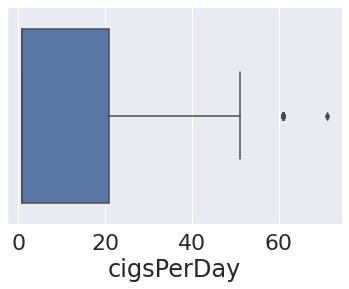

In [26]:
# Box Plot
import seaborn as sns
sns.boxplot(x_sampled['cigsPerDay'])

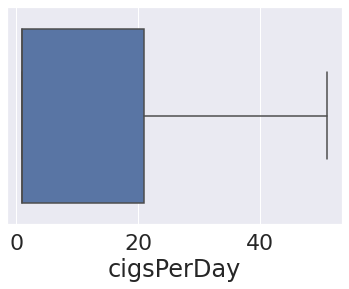

In [27]:
for i in x_sampled['cigsPerDay']:
  q1=x_sampled['cigsPerDay'].quantile(0.25)
  q3=x_sampled['cigsPerDay'].quantile(0.75)
  iqr=q3-q1
  Lower_tail=q1-1.5*iqr
  Upper_tail=q3+1.5*iqr
  if i > Upper_tail or i < Lower_tail:
    x_sampled['cigsPerDay']=x_sampled['cigsPerDay'].replace(i,np.median(x_sampled['cigsPerDay']))
sns.boxplot(x_sampled['cigsPerDay'])
plt.show()

**totChol**

<AxesSubplot:xlabel='totChol'>

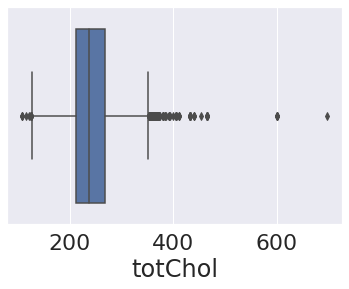

In [28]:
# Box Plot
import seaborn as sns
sns.boxplot(x_sampled['totChol'])

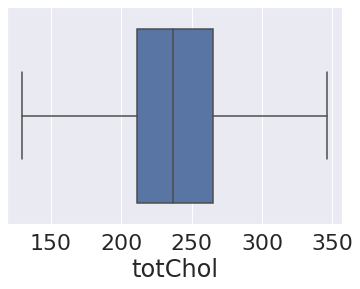

In [29]:
for i in x_sampled['totChol']:
  q1=x_sampled['totChol'].quantile(0.25)
  q3=x_sampled['totChol'].quantile(0.75)
  iqr=q3-q1
  Lower_tail=q1-1.5*iqr
  Upper_tail=q3+1.5*iqr
  if i > Upper_tail or i < Lower_tail:
    x_sampled['totChol']=x_sampled['totChol'].replace(i,np.median(x_sampled['totChol']))
sns.boxplot(x_sampled['totChol'])
plt.show()

**BMI**

<AxesSubplot:xlabel='BMI'>

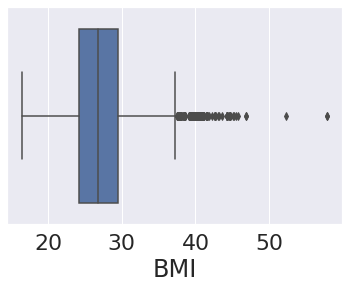

In [30]:
# Box Plot
import seaborn as sns
sns.boxplot(x_sampled['BMI'])

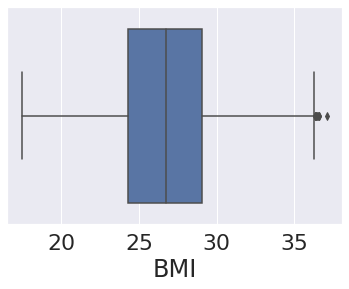

In [31]:
for i in x_sampled['BMI']:
  q1=x_sampled['BMI'].quantile(0.25)
  q3=x_sampled['BMI'].quantile(0.75)
  iqr=q3-q1
  Lower_tail=q1-1.5*iqr
  Upper_tail=q3+1.5*iqr
  if i > Upper_tail or i < Lower_tail:
    x_sampled['BMI']=x_sampled['BMI'].replace(i,np.median(x_sampled['BMI']))
sns.boxplot(x_sampled['BMI'])
plt.show()

**Glucose**

<AxesSubplot:xlabel='glucose'>

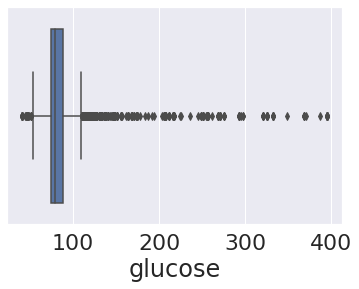

In [32]:
# Box Plot
import seaborn as sns
sns.boxplot(x_sampled['glucose'])

In [ ]:
for i in x_sampled['glucose']:
  q1=x_sampled['glucose'].quantile(0.25)
  q3=x_sampled['glucose'].quantile(0.75)
  iqr=q3-q1
  Lower_tail=q1-1.5*iqr
  Upper_tail=q3+1.5*iqr
  if i > Upper_tail or i < Lower_tail:
    x_sampled['glucose']=x_sampled['glucose'].replace(i,np.median(x_sampled['glucose']))
sns.boxplot(x_sampled['glucose'])
plt.show()

In [34]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquartile_range = quartile3 - quartile1
    low_limit = quartile1 - 1.5 * interquartile_range
    up_limit = quartile3 + 1.5 * interquartile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

for col in x_sampled.columns:
    print(col, check_outlier(x_sampled, col))

male False
age False
education False
currentSmoker False
cigsPerDay False
BPMeds True
prevalentStroke True
prevalentHyp False
diabetes True
totChol False
sysBP False
diaBP False
BMI False
heartRate False
glucose False


In [35]:
res = pd.DataFrame(x_sampled)
res['TenYearCHD'] = y_sampled
print(len(res))

7188


# ***Feature selection***

In [36]:
df3 = res.drop(['education','currentSmoker'],axis=1)
df3

,male,age,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,40,1.0,0.0,0,0,0,196.0,107.0,71.0,27.97,81.0,79.0,0
1,0,47,1.0,0.0,0,0,0,251.0,122.0,82.0,29.73,96.0,79.0,0
2,1,49,21.0,0.0,0,0,0,246.0,128.5,81.0,26.34,76.0,79.0,0
3,0,62,31.0,0.0,0,1,0,226.0,151.0,96.0,29.58,66.0,79.0,1
4,0,47,24.0,0.0,0,0,0,286.0,131.0,85.0,24.10,86.0,79.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7183,0,51,1.0,0.0,0,1,0,235.0,166.0,101.0,25.59,76.0,79.0,1
7184,1,66,7.0,0.0,0,0,0,237.0,119.5,78.5,25.30,53.0,79.0,1
7185,0,54,1.0,0.0,0,1,1,249.0,201.0,141.0,26.74,108.0,79.0,1
7186,0,45,11.0,0.0,0,0,0,222.0,111.0,77.0,23.16,65.0,79.0,1


# ***Spliting the Data***

In [37]:
X = df3.drop(['TenYearCHD'],axis=1)
y = df3['TenYearCHD']

In [38]:
X

,male,age,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,1,40,1.0,0.0,0,0,0,196.0,107.0,71.0,27.97,81.0,79.0
1,0,47,1.0,0.0,0,0,0,251.0,122.0,82.0,29.73,96.0,79.0
2,1,49,21.0,0.0,0,0,0,246.0,128.5,81.0,26.34,76.0,79.0
3,0,62,31.0,0.0,0,1,0,226.0,151.0,96.0,29.58,66.0,79.0
4,0,47,24.0,0.0,0,0,0,286.0,131.0,85.0,24.10,86.0,79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7183,0,51,1.0,0.0,0,1,0,235.0,166.0,101.0,25.59,76.0,79.0
7184,1,66,7.0,0.0,0,0,0,237.0,119.5,78.5,25.30,53.0,79.0
7185,0,54,1.0,0.0,0,1,1,249.0,201.0,141.0,26.74,108.0,79.0
7186,0,45,11.0,0.0,0,0,0,222.0,111.0,77.0,23.16,65.0,79.0


In [39]:
y

0       0
1       0
2       0
3       1
4       0
       ..
7183    1
7184    1
7185    1
7186    1
7187    1
Name: TenYearCHD, Length: 7188, dtype: int64

In [40]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=0)

# ***Cross validation***
K Fold Cross Validation

In [41]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
model=RandomForestClassifier()
from sklearn import tree
kfold_validation=KFold(n_splits=10, random_state = 42, shuffle=True)

In [42]:
import numpy as np
from sklearn.model_selection import cross_val_score
results=cross_val_score(model,X,y,cv=kfold_validation)
print(results)
print(np.mean(results))

[0.96522949 0.97774687 0.97774687 0.97635605 0.98748261 0.97635605
 0.97496523 0.97774687 0.97632312 0.97771588]
0.9767669038939104


# ***Random Forest***

In [43]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100)
classifier.fit(X_train, y_train)


# Predicting the Test set results
y_pred = classifier.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_pred, y_test)

y_pred_train = classifier.predict(X_train)
cm_train = confusion_matrix(y_pred_train, y_train)

print()
print('Accuracy for training set for Random Forest = {}'.format((cm_train[0][0] + cm_train[1][1])/len(y_train)))
print('Accuracy for test set for Random Forest = {}'.format((cm_test[0][0] + cm_test[1][1])/len(y_test)))

pred_prob1 = classifier.predict_proba(X_test)
from sklearn.metrics import roc_auc_score
 
#AUC scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])

print(" AUC Score:", auc_score1) 

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))


Accuracy for training set for Random Forest = 1.0
Accuracy for test set for Random Forest = 0.9564209550301345
 AUC Score: 0.9916975470513889
[[ 996   74]
 [  20 1067]]


              precision    recall  f1-score   support

           0       0.98      0.93      0.95      1070
           1       0.94      0.98      0.96      1087

    accuracy                           0.96      2157
   macro avg       0.96      0.96      0.96      2157
weighted avg       0.96      0.96      0.96      2157



# ***Logistics Regression***

In [44]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0, solver='lbfgs')
classifier.fit(X_train, y_train)

start = time.time()

# Predicting the Test set results
y_pred = classifier.predict(X_test)

from sklearn.metrics import confusion_matrix, precision_score
cm_test = confusion_matrix(y_pred, y_test)

y_pred_train = classifier.predict(X_train)
cm_train = confusion_matrix(y_pred_train, y_train)
pred_prob2 = classifier.predict_proba(X_test)
from sklearn.metrics import roc_auc_score
 
#AUC scores
auc_score2 = roc_auc_score(y_test, pred_prob1[:,1])

print(" AUC Score:", auc_score1) 

print()
print('Accuracy for training set for Logistic Regression = {}'.format((cm_train[0][0] + cm_train[1][1])/len(y_train)))
print('Accuracy for test set for Logistic Regression = {}'.format((cm_test[0][0] + cm_test[1][1])/len(y_test)))

print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))
end = time.time()
diff = end - start
print('Execution time:', diff)

 AUC Score: 0.9916975470513889

Accuracy for training set for Logistic Regression = 0.671039554760485
Accuracy for test set for Logistic Regression = 0.6685210941121928
[[742 328]
 [387 700]]


              precision    recall  f1-score   support

           0       0.66      0.69      0.67      1070
           1       0.68      0.64      0.66      1087

    accuracy                           0.67      2157
   macro avg       0.67      0.67      0.67      2157
weighted avg       0.67      0.67      0.67      2157

Execution time: 0.03205275535583496


# ***Support Vector Machine***
**SVM**

In [45]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

SVC(kernel='linear')

In [46]:
y_pred = svclassifier.predict(X_test)

print('Accuracy for training set for SVM = {}'.format((cm_train[0][0] + cm_train[1][1])/len(y_train)))
print('Accuracy for test set for SVM = {}'.format((cm_test[0][0] + cm_test[1][1])/len(y_test)))

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))
pred_prob3 = classifier.predict_proba(X_test)
from sklearn.metrics import roc_auc_score
 
#AUC scores
auc_score3 = roc_auc_score(y_test, pred_prob1[:,1])

print(" AUC Score:", auc_score1) 

Accuracy for training set for SVM = 0.671039554760485
Accuracy for test set for SVM = 0.6685210941121928
[[731 339]
 [388 699]]


              precision    recall  f1-score   support

           0       0.65      0.68      0.67      1070
           1       0.67      0.64      0.66      1087

    accuracy                           0.66      2157
   macro avg       0.66      0.66      0.66      2157
weighted avg       0.66      0.66      0.66      2157

 AUC Score: 0.9916975470513889


**Kernal SVM**

In [47]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='poly', degree=8)
svclassifier.fit(X_train, y_train)

SVC(degree=8, kernel='poly')

In [48]:
y_pred = svclassifier.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))
pred_prob4 = classifier.predict_proba(X_test)
from sklearn.metrics import roc_auc_score
 
#AUC scores
auc_score4 = roc_auc_score(y_test, pred_prob1[:,1])

print(" AUC Score:", auc_score1) 

[[792 278]
 [442 645]]


              precision    recall  f1-score   support

           0       0.64      0.74      0.69      1070
           1       0.70      0.59      0.64      1087

    accuracy                           0.67      2157
   macro avg       0.67      0.67      0.66      2157
weighted avg       0.67      0.67      0.66      2157

 AUC Score: 0.9916975470513889


# ***LightGBM***

In [49]:
import lightgbm as lgb

d_train = lgb.Dataset(X_train, label = y_train)
params = {}

clf = lgb.train(params, d_train, 100)
#Prediction
y_pred = clf.predict(X_test)
#convert into binary values
for i in range(0, len(y_pred)):
    if y_pred[i]>= 0.5:       # setting threshold to .5
       y_pred[i]=1
    else:
       y_pred[i]=0

from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_pred, y_test)

y_pred_train = clf.predict(X_train)
for i in range(0, len(y_pred_train)):
    if y_pred_train[i]>= 0.5:       # setting threshold to .5
       y_pred_train[i]=1
    else:
       y_pred_train[i]=0

cm_train = confusion_matrix(y_pred_train, y_train)
print(confusion_matrix(y_test, y_pred))
pred_prob5 = classifier.predict_proba(X_test)
from sklearn.metrics import roc_auc_score
 
#AUC scores
auc_score5 = roc_auc_score(y_test, pred_prob1[:,1])

print(" AUC Score:", auc_score1) 
print()
print('Accuracy for training set for LightGBM = {}'.format((cm_train[0][0] + cm_train[1][1])/len(y_train)))
print('Accuracy for test set for LightGBM = {}'.format((cm_test[0][0] + cm_test[1][1])/len(y_test)))
print(classification_report(y_test, y_pred))

[[847 223]
 [ 92 995]]
 AUC Score: 0.9916975470513889

Accuracy for training set for LightGBM = 0.9526933015305108
Accuracy for test set for LightGBM = 0.8539638386648123
              precision    recall  f1-score   support

           0       0.90      0.79      0.84      1070
           1       0.82      0.92      0.86      1087

    accuracy                           0.85      2157
   macro avg       0.86      0.85      0.85      2157
weighted avg       0.86      0.85      0.85      2157



# ***ROC***

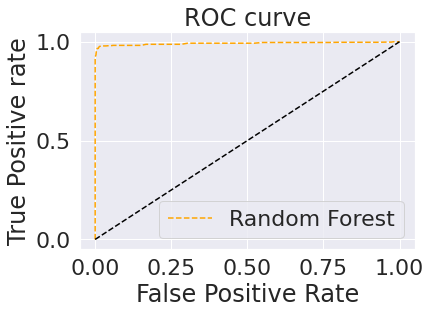

In [50]:
from sklearn.metrics import roc_curve

fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)

#ROC curve for TPR=FPR
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
#Plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Random Forest')
plt.plot(p_fpr, p_tpr, linestyle='--', color='black')
#title
plt.title('ROC curve')
#x-label
plt.xlabel('False Positive Rate')
#y-label
plt.ylabel('True Positive rate')
 
plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

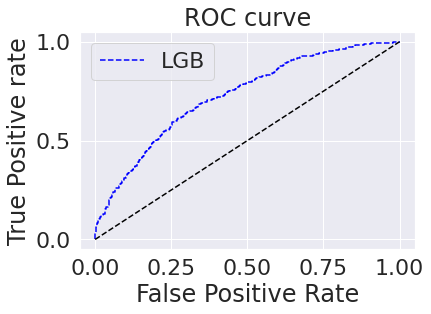

In [51]:
from sklearn.metrics import roc_curve


fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_prob4[:,1], pos_label=1)
fpr5, tpr5, thresh5 = roc_curve(y_test, pred_prob5[:,1], pos_label=1)
#ROC curve for TPR=FPR
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
#Plot roc curves
# plt.plot(fpr2, tpr2, linestyle='--',color='green', label='LR')
# plt.plot(fpr3, tpr3, linestyle='--',color='red', label='SVM')
# plt.plot(fpr4, tpr4, linestyle='--',color='yellow', label='KSVM')
plt.plot(fpr5, tpr5, linestyle='--',color='blue', label='LGB')
plt.plot(p_fpr, p_tpr, linestyle='--', color='black')
#title
plt.title('ROC curve')
#x-label
plt.xlabel('False Positive Rate')
#y-label
plt.ylabel('True Positive rate')
 
plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

# ***training model on same dataset***

For manual checking

In [52]:
Data_X = df3.iloc[:, :-1]

In [53]:
Data_X.head()

,male,age,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,1,40,1.0,0.0,0,0,0,196.0,107.0,71.0,27.97,81.0,79.0
1,0,47,1.0,0.0,0,0,0,251.0,122.0,82.0,29.73,96.0,79.0
2,1,49,21.0,0.0,0,0,0,246.0,128.5,81.0,26.34,76.0,79.0
3,0,62,31.0,0.0,0,1,0,226.0,151.0,96.0,29.58,66.0,79.0
4,0,47,24.0,0.0,0,0,0,286.0,131.0,85.0,24.10,86.0,79.0


In [54]:
Data_Y = df3.iloc[:,-1]

In [55]:
Data_Y.head()

0    0
1    0
2    0
3    1
4    0
Name: TenYearCHD, dtype: int64

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [57]:
X_train,X_test,y_train,y_test=train_test_split(Data_X,Data_Y,random_state=0,test_size=0.2)

In [58]:
clf=RandomForestClassifier()

In [59]:
clf.fit(X_train,y_train)

RandomForestClassifier()

In [60]:
clf.score(X_test,y_test)

0.9659248956884562

# ***Loading Test Dataset and Then Training Model***

Manual Checking

In [62]:
tdf = pd.read_csv("heart_test2.csv")
#row 17 and from 30-45

In [63]:
tdf.head()

,male,age,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,0,39,21,0,0,1,0,222,141.0,91,22.35,96,71
1,0,47,1,0,0,0,0,251,122.0,82,29.73,96,77
2,1,49,21,0,0,0,0,246,128.5,81,26.34,76,71
3,0,62,31,0,0,1,0,226,151.0,96,29.58,66,79
4,0,47,24,0,0,0,0,286,131.0,85,24.10,86,86


In [64]:
e=tdf['age'].values

In [65]:
X_train= Data_X
y_train=Data_Y

In [66]:
X_test= tdf

In [67]:
from sklearn.ensemble import RandomForestClassifier

In [68]:
rm=RandomForestClassifier(n_estimators=100).fit(X_train,np.ravel(y_train))

In [69]:
rm_pred=rm.predict(X_test)

In [70]:
f={'age':e,'TenYearCHD':rm_pred }

In [71]:
final=pd.DataFrame(f)

In [72]:
final.groupby('TenYearCHD').count()

,age
TenYearCHD,
0,12
1,3


In [73]:
final.to_csv('heart_submit.csv',index=False)

# ***Model Deployment***

In [74]:
import pickle

In [75]:
pickle.dump(classifier, open('model.pkl', 'wb'))

In [76]:
pickle_read = pickle.load(open('model.pkl', 'rb'))